# OCR experiment

This notebook compares the OCR results embedded in the textbook scans to those of eric's api, and MS oxford alone

bash curl -H "Content-Type: application/json" -X POST -d '{"url":" http://dgmde20.com/img/lorem-ipsum-2.png"}' http://dev-ocr.ai2:/v1/ocr

In [1]:
%%capture
import numpy as np
import pandas as pd
import scipy.stats as st
import itertools
import math
from collections import Counter, defaultdict, OrderedDict
%load_ext autoreload
%autoreload 2

In [2]:
import cv2
import pprint
import pickle
import json
import requests
import io

In [3]:
import pdfextraction.ocr_pipeline

In [18]:
def load_book_info():
    with open('./breakdowns.pkl', 'rb') as f:
        # book_breakdowns = pickle.load(f, encoding='latin1')
        book_breakdowns = pickle.load(f)

    with open('pdfs/page_ranges.csv') as f:
        ranges = f.readlines()
    range_lookup = {line.split(' ')[0]:[int(num) for num in line.strip().split(' ')[1:]] for line in ranges}
    return book_breakdowns, range_lookup

In [73]:
def query_vision_ocr(image_url, merge_boxes=False, include_merged_components=False, as_json=True):
    api_entry_point = 'http://vision-ocr.dev.allenai.org/v1/ocr'
    header = {'Content-Type': 'application/json'}
    request_data = {
        'url': image_url,
        # 'maximumSizePixels': max_pix_size,
        'mergeBoxes': merge_boxes,
        'includeMergedComponents': include_merged_components
    }

    json_data = json.dumps(request_data)
    response = requests.post(api_entry_point, data=json_data, headers=header)
    print(response.reason)
    json_response = json.loads(response.content.decode())
    if as_json:
        response = json_response
    return response

def form_image_url(book_name, page_n, ):
    book_name_no_ext = book_name.replace('.pdf', '_')
    image_base = 'https://s3-us-west-2.amazonaws.com/ai2-vision-turk-data/textbook-annotation-test/page-images/'
    return image_base + book_name_no_ext + str(page_n) + '.jpeg'

point_to_tuple = lambda box: tuple(OrderedDict(sorted(box.items())).values())
get_bbox_tuples = lambda detection: map(point_to_tuple, detection['rectangle'])

In [74]:
book_breakdowns, page_ranges = load_book_info()

In [75]:
test_page = form_image_url(book_breakdowns['daily_sci'][4], 153)
test_page

'https://s3-us-west-2.amazonaws.com/ai2-vision-turk-data/textbook-annotation-test/page-images/Daily_Science_Grade_5_Evan_Moor_153.jpeg'

In [76]:
ocr_res = query_vision_ocr(test_page)

OK


In [77]:
ocr_res['detections']

[{u'rectangle': [{u'x': 199, u'y': 449}, {u'x': 382, u'y': 504}],
  u'score': 1.0,
  u'value': u'eview'},
 {u'rectangle': [{u'x': 2101, u'y': 159}, {u'x': 2253, u'y': 229}],
  u'score': 1.0,
  u'value': u'scieoe'},
 {u'rectangle': [{u'x': 248, u'y': 1318}, {u'x': 289, u'y': 1355}],
  u'score': 1.0,
  u'value': u'2.'},
 {u'rectangle': [{u'x': 1994, u'y': 157}, {u'x': 2200, u'y': 217}],
  u'score': 1.0,
  u'value': u'aily Scie'},
 {u'rectangle': [{u'x': 140, u'y': 226}, {u'x': 251, u'y': 269}],
  u'score': 1.0,
  u'value': u'Name'},
 {u'rectangle': [{u'x': 1974, u'y': 287}, {u'x': 2224, u'y': 424}],
  u'score': 1.0,
  u'value': u'Big'},
 {u'rectangle': [{u'x': 200, u'y': 375}, {u'x': 338, u'y': 432}],
  u'score': 1.0,
  u'value': u'Unit'},
 {u'rectangle': [{u'x': 439, u'y': 363}, {u'x': 858, u'y': 425}],
  u'score': 1.0,
  u'value': u'Comprehension'},
 {u'rectangle': [{u'x': 1985, u'y': 427}, {u'x': 2215, u'y': 484}],
  u'score': 1.0,
  u'value': u'Idea 5'},
 {u'rectangle': [{u'x': 199, 

In [36]:
for det in ocr_res['detections']:
    print(det['value'], '\n')

(u'scieoe Big Idea 2', '\n')
(u'scieoe', '\n')
(u'Big', '\n')
(u'Idea 2', '\n')
(u'Name', '\n')
(u'Day 4', '\n')
(u'Day', '\n')
(u'4', '\n')
(u"Weekly Question re all germs bad? Scientists are finding many uses for bacteria. Since bacteria are such good decomposers, they can be used to clean up waste. One type of bacteria digests oil. People use it to repair damage from oil spills, both in the ocean and on roads. Other bacteria are good at breaking down toxic substances in sewage, so these bacteria are used in water treatment plants Scientists are also exploring ways to get bacteria to produce energy. Scientists have created simple fuel cells, which are like batteries, that use bacteria to convert garbage into electricity. These fuel cells may someday recycle waste into electricity during space flights. So are all germs bad? Not at all. In fact, tiny bacteria may soon provide the solutions to some of Earth's biggest problems.", '\n')
(u'Weekly Question', '\n')
(u're all germs bad?', '\

In [24]:
def display_page(raw_page_img, page_layout):
    page_png_stream, y_height = make_png_stream(raw_page_img)
    page_img = make_open_cv_img(page_png_stream)
    for box in page_layout._objs:
        lr, ul = get_bbox_tuple(box, y_height)
        try:
            # print box.get_text()
            pass
        except AttributeError:
            pass
        cv2.rectangle(page_img, ul, lr, color=random_color(), thickness=2)
    display(Image.fromarray(page_img, 'RGB'))


def draw_pdf_with_boxes(book_file, page_range, word_margin=0.1, line_overlap=0.5, char_margin=2.0,
                        line_margin=0.5, boxes_flow=0.5):
    if page_range:
        page_range = map(lambda x: x - 1, page_range)
        suffix = '[{}-{}]'.format(page_range[0], page_range[1])
        raw_multi_pdf = WImage(filename=book_file + suffix)
    else:
        raw_multi_pdf = WImage(filename=book_file)
        
    doc_page_layouts = make_page_layouts(book_file, page_range,
                                         line_overlap,
                                         char_margin,
                                         line_margin,
                                         word_margin,
                                         boxes_flow)
    page_images = raw_multi_pdf.sequence
    for page_n in range(len(page_images)):
        display_page(page_images[page_n], doc_page_layouts[page_n])

In [47]:
import base64
from wand.image import Image as WImage
from IPython.display import display
import PIL.Image as Image

In [56]:
req = requests.get(test_page)
tpi = Image.open(io.BytesIO(req.content))
# tpi.thumbnail((1000,1000))

In [58]:
# display(tpi)

In [34]:
def random_color():
    import random
    return random.randint(0,255), random.randint(0,255), random.randint(0,255)

In [31]:
def display_page(raw_page_img):
    page_png_stream, y_height = make_png_stream(raw_page_img)
    page_img = make_open_cv_img(page_png_stream)
    for box in page_layout._objs:
        lr, ul = get_bbox_tuple(box, y_height)
        try:
            # print box.get_text()
            pass
        except AttributeError:
            pass
        cv2.rectangle(page_img, ul, lr, color=random_color(), thickness=2)
    display(Image.fromarray(page_img, 'RGB'))

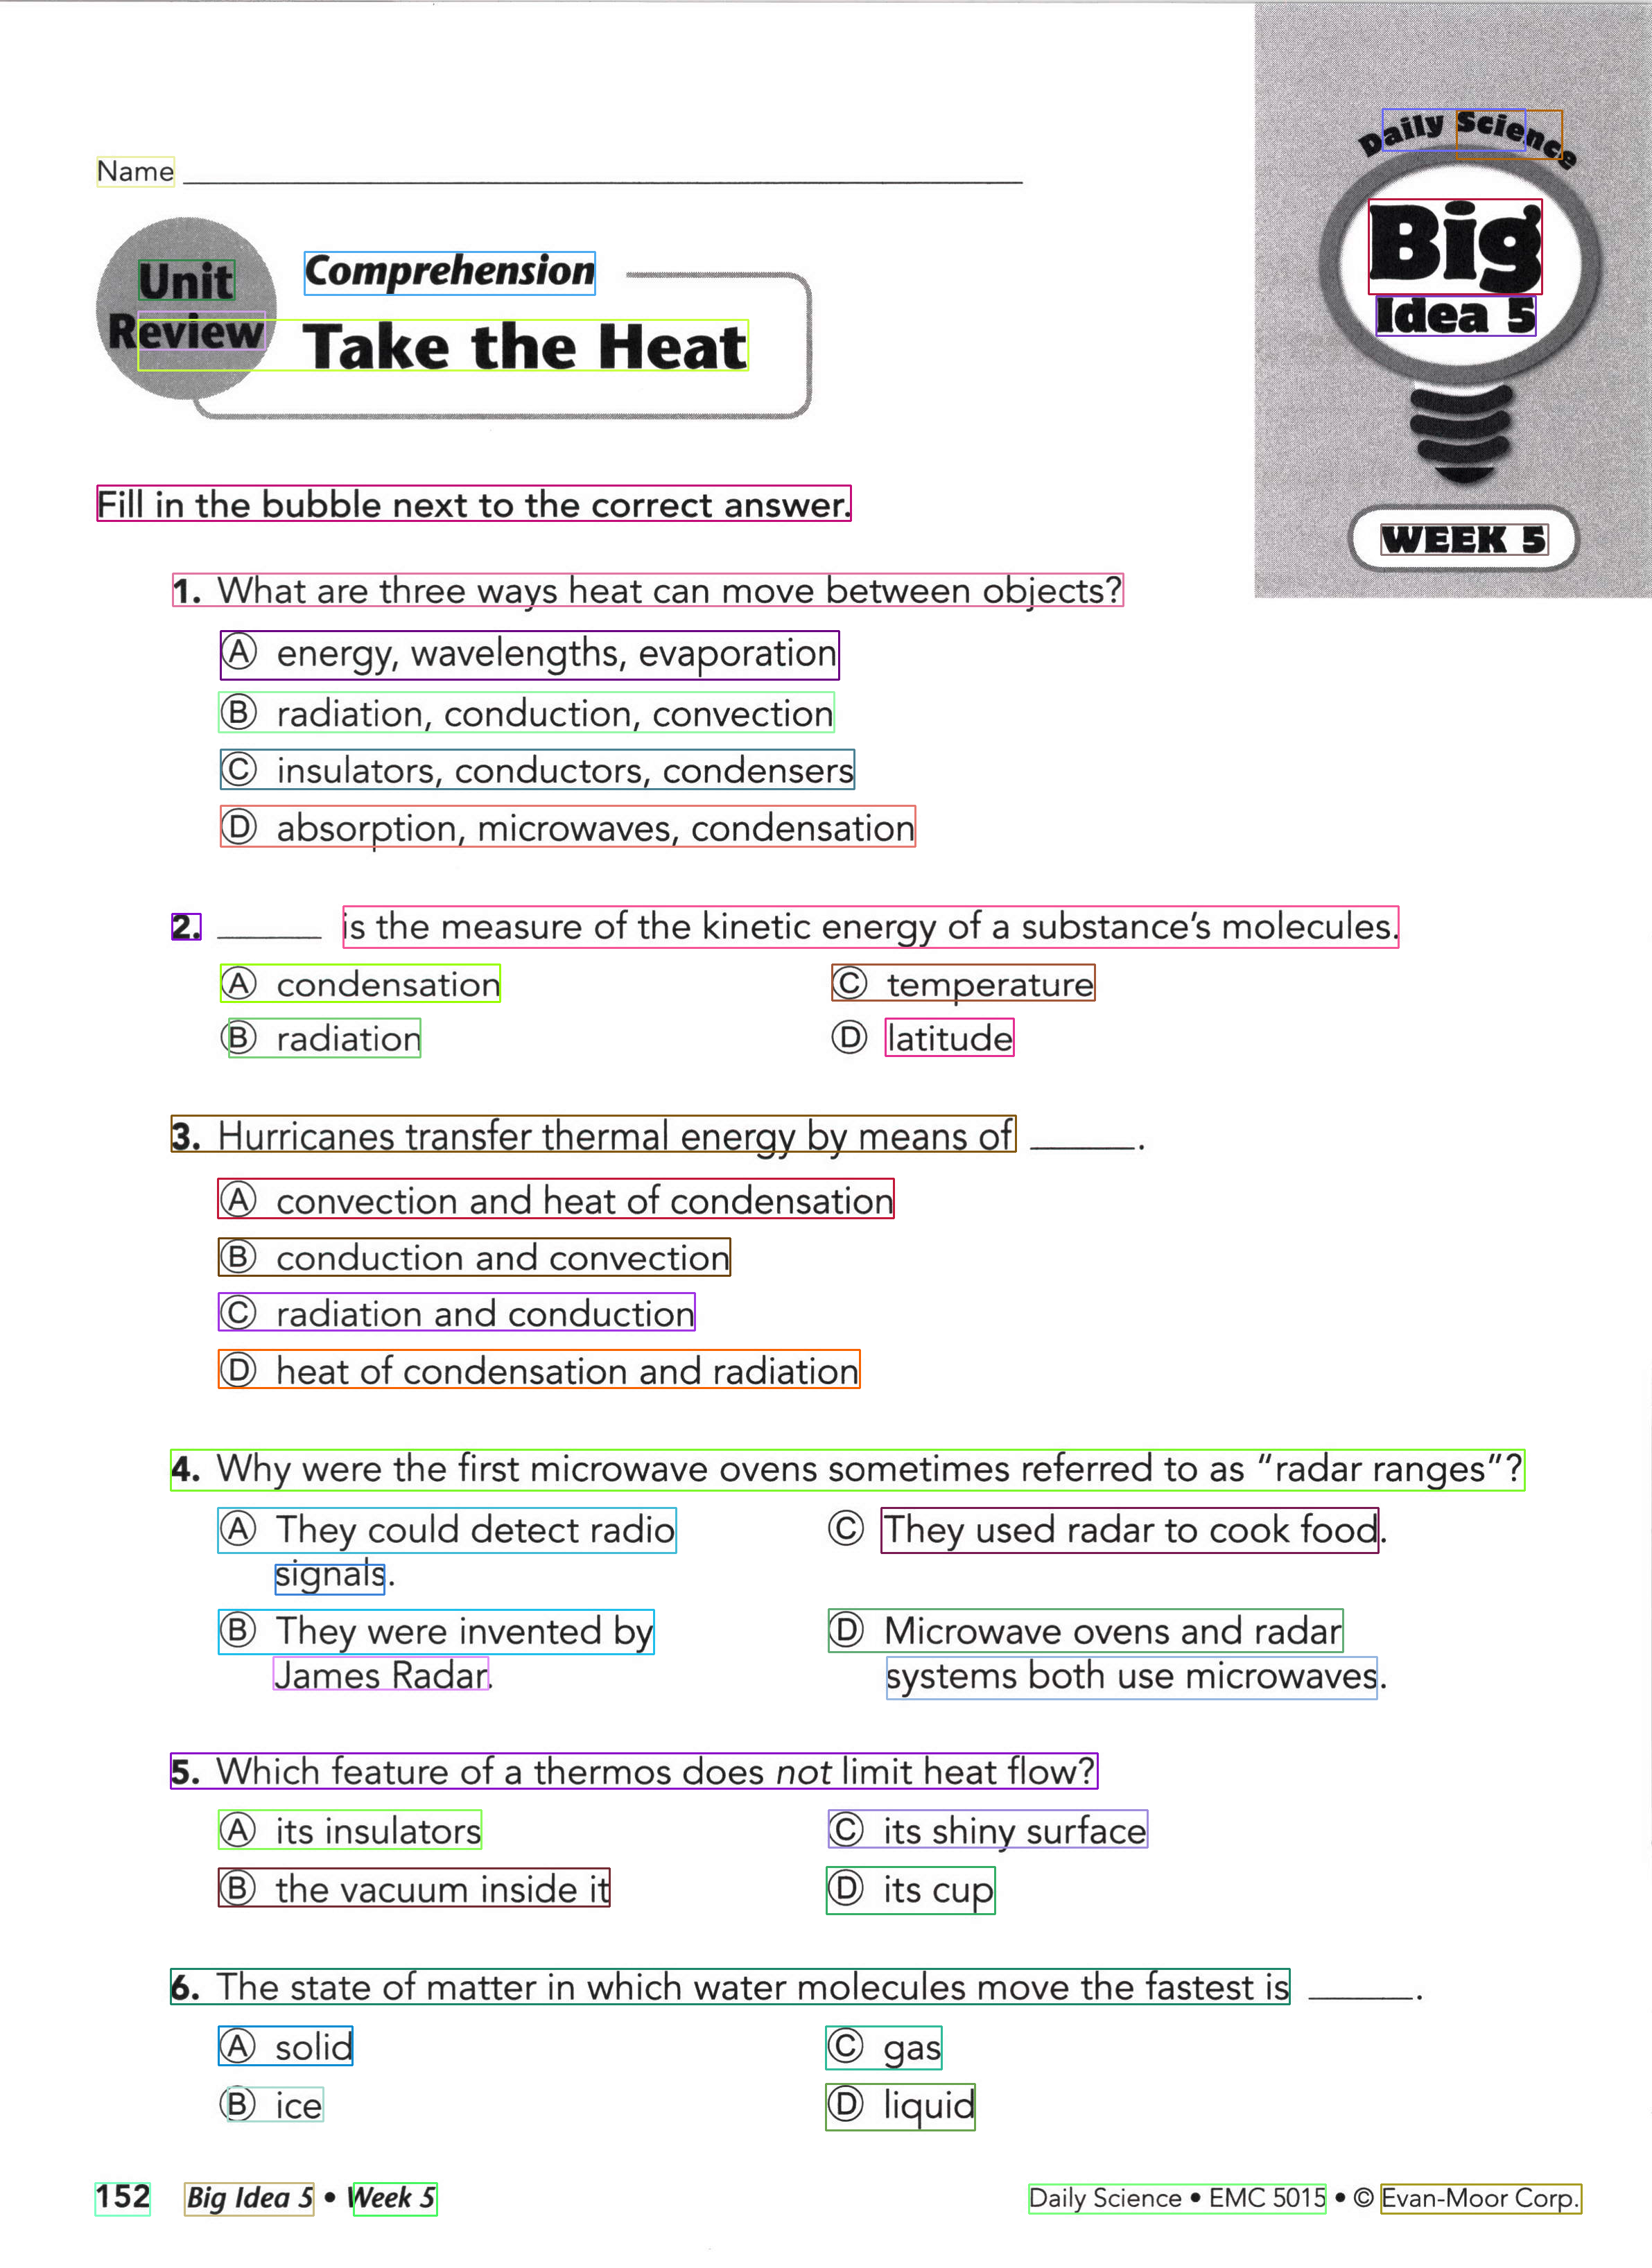

In [68]:
pil_image = tpi.convert('RGB') 
open_cv_image = np.array(pil_image) 
open_cv_image = open_cv_image[:, :, ::-1].copy() 

for box in ocr_res['detections']:
    lr, ul = get_bbox_tuples(box)
    cv2.rectangle(open_cv_image, ul, lr, color=random_color(), thickness=2)
display(Image.fromarray(open_cv_image, 'RGB'))

In [108]:
class Detection:

    def __init__(self, start_x, start_y, end_x, end_y, value, score):
        self.start_x = start_x
        self.start_y = start_y
        self.end_x = end_x
        self.end_y = end_y
        self.value = value
        self.score = score

    def height(self):
        return self.end_y - self.start_y

    def width(self):
        return self.end_x - self.start_x

    def average_character_length(self):
        return (self.end_x - self.start_x)/float(len(self.value))

    def horizontal_near(self, other_detection):
        distance = abs(other_detection.start_x - self.end_x)
        from pprint import pprint

        return distance/other_detection.average_character_length() < 2.0



    def merge(self, other_detection):
        self.start_x = min(self.start_x, other_detection.start_x)
        self.start_y = min(self.start_y, other_detection.start_y)
        self.end_x = max(self.end_x, other_detection.end_x)
        self.end_y = max(self.end_y, other_detection.end_y)
        self.value += " " + other_detection.value

    def to_JSON(self):
        return {
            'rectangle':[{'x':self.start_x, 'y':self.start_y}, {'x':self.end_x, 'y':self.end_y}],
            'value': self.value,
            'score': self.score}

    def __repr__(self):
        return json.dumps(self.to_JSON())


In [109]:
def merge_boxes(detections, threshold=1.0):
    rectangle_groups = []
    for current_d in detections:
        found_group = False
        for g in rectangle_groups:
            if not found_group:
                for d in g:
                    # current_height = current_r[1][1] - current_r[0][1]
                    y_distance = min(abs(d.start_y - current_d.end_y), abs(current_d.start_y - d.end_y))
                    if y_distance < (d.height() * threshold) and current_d.start_x < d.end_x and current_d.end_x > d.start_x:
                        g.append(current_d)
                        found_group = True
                        break
        if not found_group:
            rectangle_groups.append([current_d])

    new_detections = []
    for g in rectangle_groups:
        if len(g) == 1:
            new_detections.append(g[0])
        else:
            min_x = min(map(lambda x: x.start_x, g))
            max_x = max(map(lambda x: x.end_x, g))
            min_y = min(map(lambda x: x.start_y, g))
            max_y = max(map(lambda x: x.end_y, g))
            words = ' '.join(map(lambda x: x.value, g))
            score = ' '.join(map(lambda x: str(x.score), g))
            detection = Detection(min_x, min_y, max_x, max_y, words, score)
            new_detections.append(detection)
    return new_detections

In [110]:
det_obj = det_json_to_obj(ocr_res['detections'])
merged_detections = merge_boxes(det_obj)

In [111]:
def det_json_to_obj(detections):
    return [Detection(det['rectangle'][0]['x'],det['rectangle'][0]['y'], det['rectangle'][1]['x'],det['rectangle'][1]['y'], det['value'], det['score']) for det in detections]

In [112]:
merged_detections[0]

{"score": "1.0 1.0 1.0", "value": "eview Unit eview Take the Heat", "rectangle": [{"y": 375, "x": 199}, {"y": 534, "x": 1079}]}

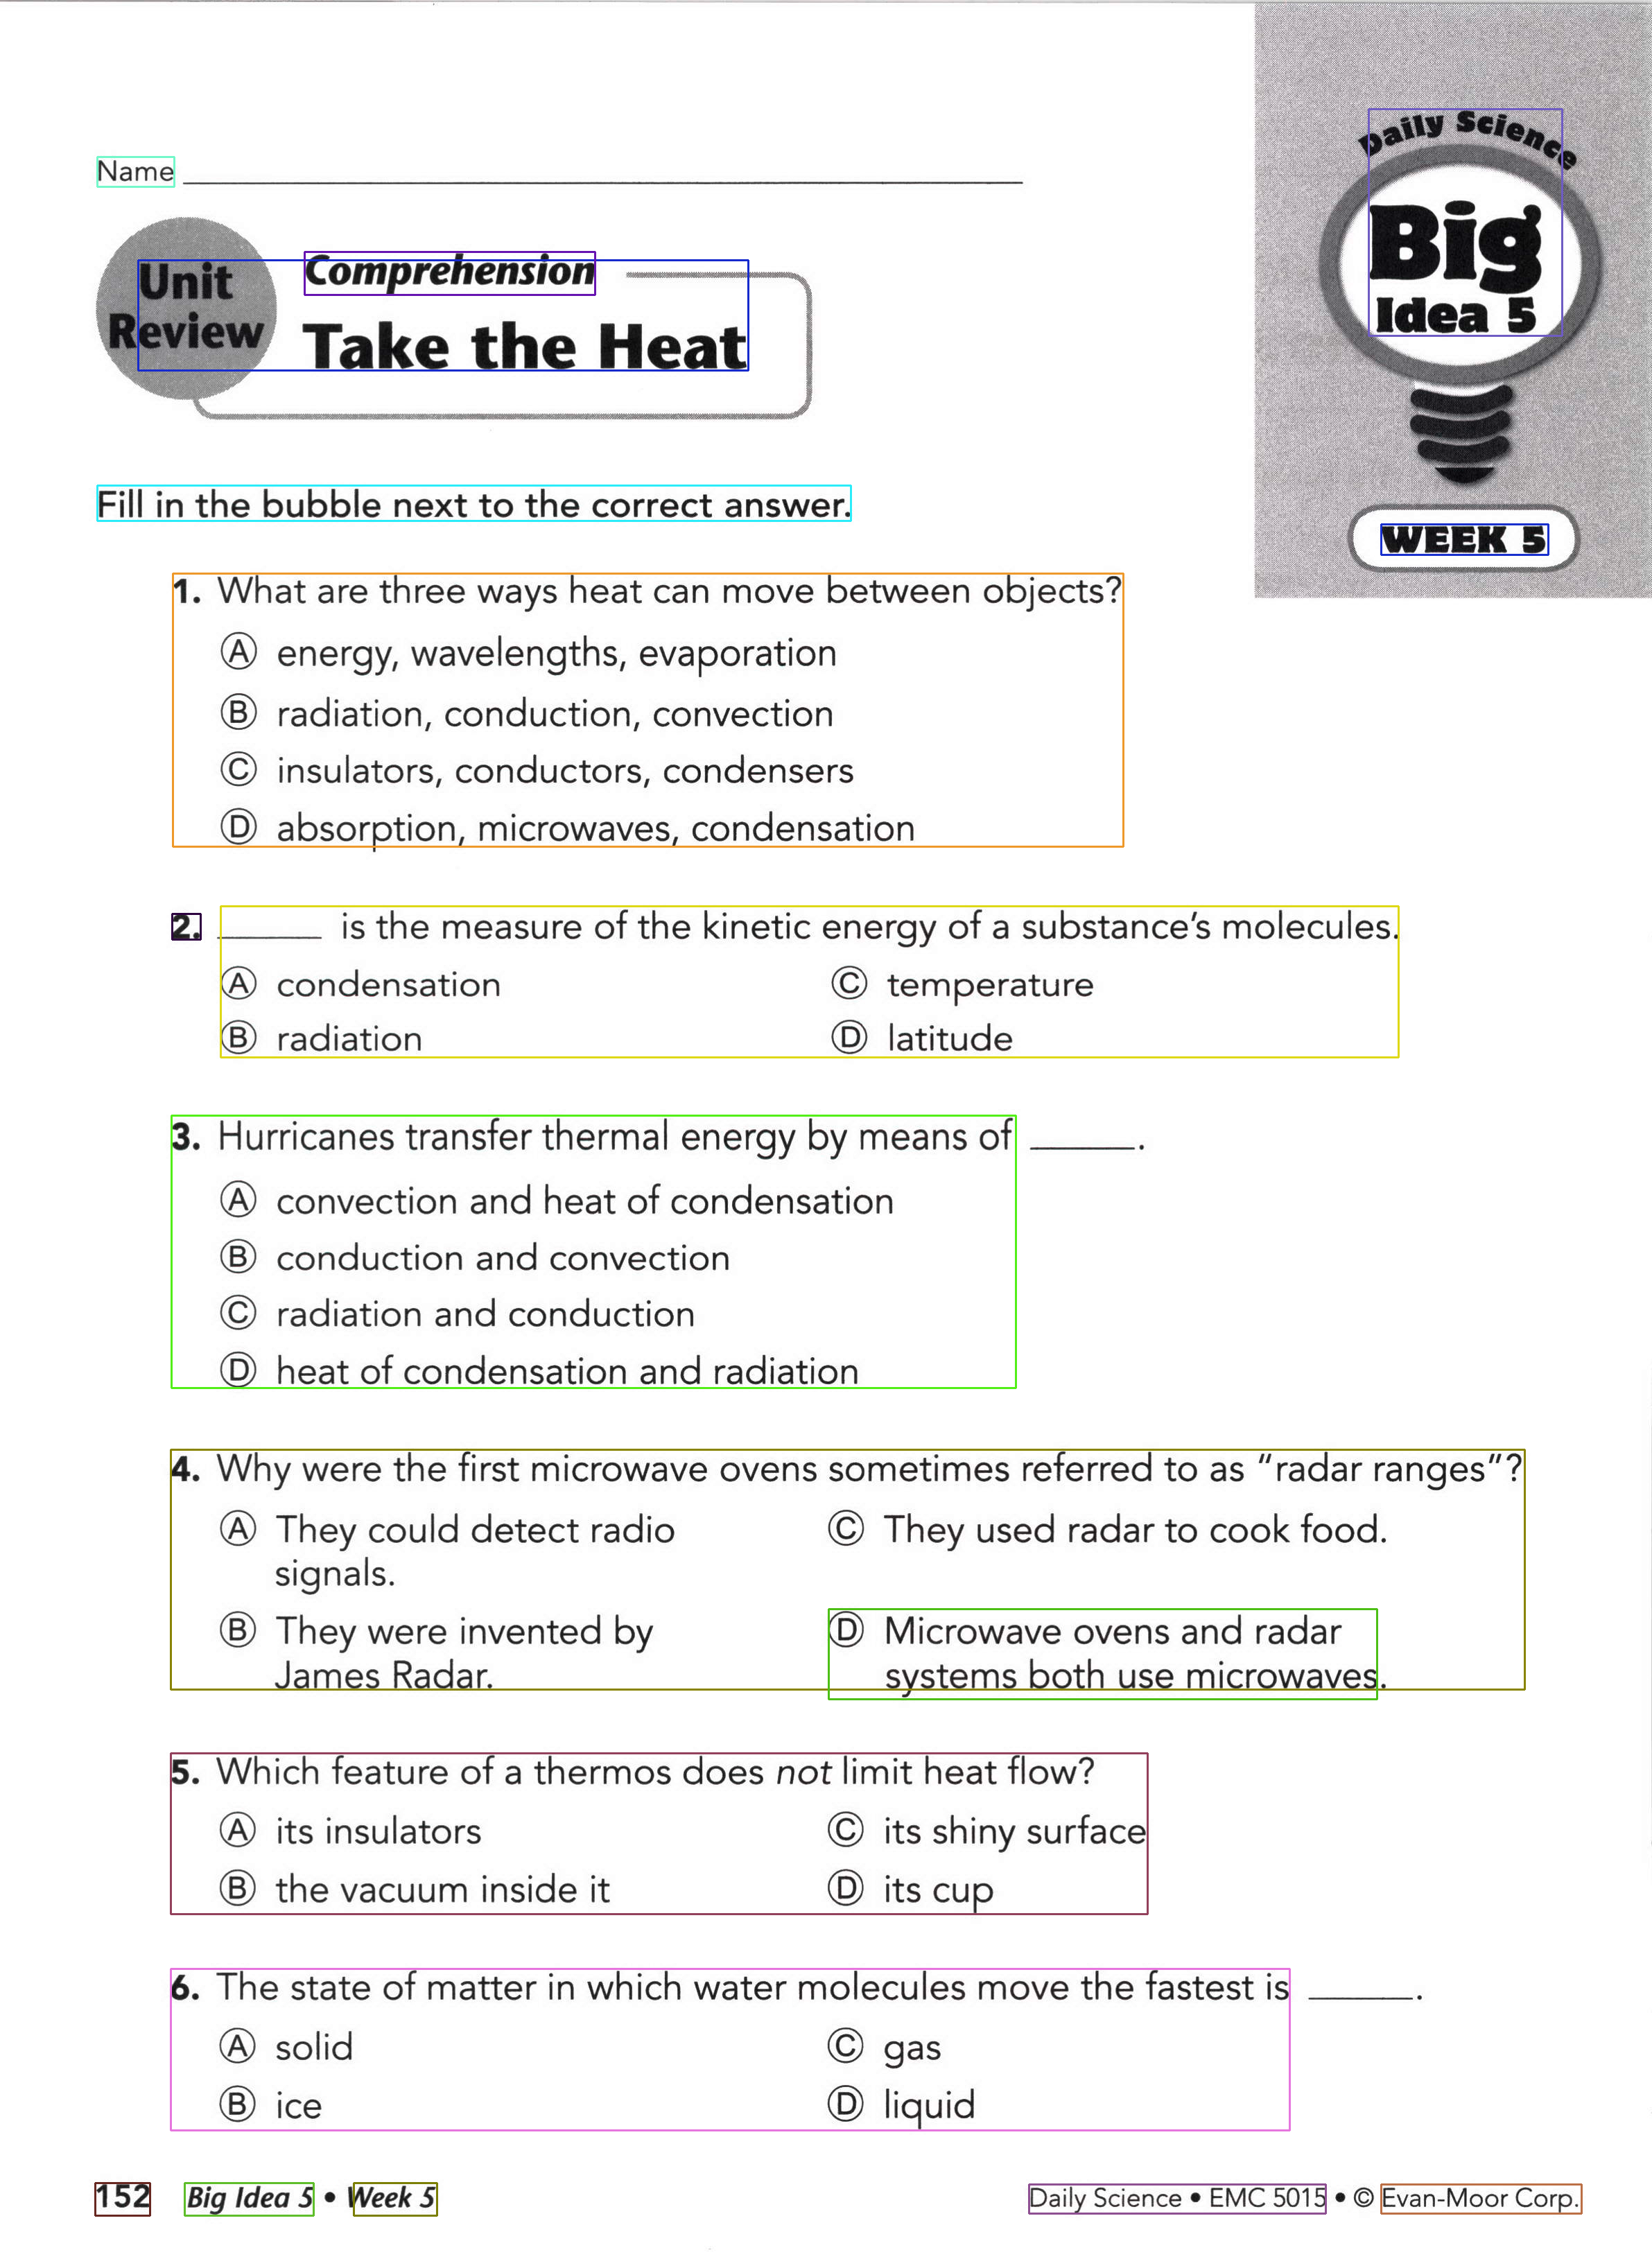

In [113]:
pil_image = tpi.convert('RGB') 
open_cv_image = np.array(pil_image) 
open_cv_image = open_cv_image[:, :, ::-1].copy() 

for box in merged_detections:
    lr, ul = get_bbox_tuples(box.to_JSON())
    cv2.rectangle(open_cv_image, ul, lr, color=random_color(), thickness=2)
display(Image.fromarray(open_cv_image, 'RGB'))